1. Import and Install Dependencies

In [1]:
!python3 -m pip install --upgrade pip

In [2]:
%pip install --upgrade mediapipe

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade protobuf==4.25.3

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow opencv-python scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.symbol_database")

2024-11-22 09:07:39.042730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 09:07:39.047098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 09:07:39.119530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 09:07:39.155351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732246659.223702    5894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732246659.23

2. Keypoints using MP Holistic

In [6]:
mp_holistic = mp.solutions.holistic #to detect
mp_drawing = mp.solutions.drawing_utils # to draw
mp_face_mesh = mp.solutions.face_mesh  # for face mesh connections

In [7]:
def mediapipe_detection(image, model):  # pass image and model
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # bgr 2 rgb
    image.flags.writeable = False 
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [8]:
def draw_landmarks(image, results):  # draw landmarks
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)  # face landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # pose landmarks
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # left hand landmarks
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # right hand landmarks


In [9]:
def draw_styled_landmarks(image, results):  # draw styled landmarks
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [10]:
# def draw_landmarks(image, results): #draw landmarks
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) #face landmarks
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) #pose landmarks
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #left hand landmarks
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #right hand landmarks

In [11]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
    
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        draw_styled_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732246669.761688    8432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732246669.803692    8432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732246669.808022    8429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732246669.810553    8431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732246669.812115    8428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732246669.819472    8

<class 'mediapipe.python.solution_base.SolutionOutputs'>


QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is n

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [12]:
results

mediapipe.python.solution_base.SolutionOutputs

In [13]:
draw_styled_landmarks(image, results)

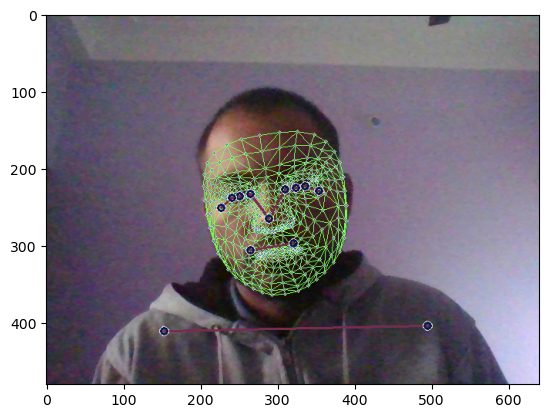

In [14]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

3. Extract Keypoint Values

In [15]:
results.pose_landmarks.landmark[0].visibility

0.9997477531433105

In [16]:
# pose = []
# for res in results.pose_landmarks.landmark:
#     test = np.array([res.x, res.y, res.z, res.visibility])
#     pose.append(test)

In [17]:
print(len(results.pose_landmarks.landmark))
# print(len(results.left_hand_landmarks.landmark))
# print(len(results.right_hand_landmarks.landmark))
# print(len(results.face_landmarks.landmark))

33


In [18]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

In [19]:
pose.shape

(132,)

In [20]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose, face, lh, rh])

In [21]:
result_test=extract_keypoints(results)

In [22]:
result_test

array([ 0.45200473,  0.55236012, -1.25426316, ...,  0.        ,
        0.        ,  0.        ])

In [23]:
np.save('0', result_test)

In [24]:
np.load('0.npy')

array([ 0.51474047,  0.61147982, -0.72919238, ...,  0.        ,
        0.        ,  0.        ])

In [23]:
extract_keypoints(results).shape
#468*3+33*4+21*3+21*3 

(1662,)

4. Setup Folders for Collection

In [24]:
#export numpy array data
DATA_PATH = os.path.join('MP_Data')

#actions that we try to detect
actions = np.array(['hello','Bharati Bharat', 'Sign', 'Bhasha', 'Bye Bye', 'Phir Se', 'Main', 'Tu Tum Aap' , 'Aadmi Mard', 'Aurat Nari' , 
                    'Badhir (Deaf)', 'Hearing' , 'Shikshak' ,'Dhanyawad', 'Welcome' ,'Maafi Kshama' , 'Namaste' ])

#Thirty videos worth of data
no_sequences = 40

#Videos are going to be of 30 frames in length
sequence_length = 30

start_folder = 30

In [25]:
#hello
#thanks
#i love you

In [26]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

5. Collect Keypoint Values for Training and Testing

In [27]:
cap.release()
cv2.destroyAllWindows()

In [34]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # NEW Pause and wait for 'n' key press to continue
                while True:
                    key = cv2.waitKey(0) & 0xFF  # Wait indefinitely for a key press
                    if key == ord('n'):  # If 'n' is pressed, break out of the loop
                        break
                    elif key == ord('q'):  # If 'q' is pressed, exit gracefully
                        cap.release()
                        cv2.destroyAllWindows()
                        exit()
                    
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

FileNotFoundError: [Errno 2] No such file or directory: 'MP_Data\\Aap Kaise Hain \\0\\0.npy'

6. Preprocess Data and Create Labels and Features

In [28]:
from sklearn.model_selection  import train_test_split
from tensorflow.keras.utils import to_categorical

In [29]:
label_map={label:num for num, label in enumerate(actions)}

In [30]:
label_map

{'hello': 0,
 'Bharati Bharat': 1,
 'Sign': 2,
 'Bhasha': 3,
 'Bye Bye': 4,
 'Phir Se': 5,
 'Main': 6,
 'Tu Tum Aap': 7,
 'Aadmi Mard': 8,
 'Aurat Nari': 9,
 'Badhir (Deaf)': 10,
 'Hearing': 11,
 'Shikshak': 12,
 'Dhanyawad': 13,
 'Welcome': 14,
 'Maafi Kshama': 15,
 'Namaste': 16}

In [31]:
sequences, labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        

In [32]:
np.array(sequences).shape

(680, 30, 1662)

In [33]:
np.array(labels).shape

(680,)

In [34]:
X = np.array(sequences)

In [35]:
X.shape

(680, 30, 1662)

In [36]:
y = to_categorical(labels).astype(int)

In [37]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [39]:
X_train.shape

(646, 30, 1662)

In [40]:
X_test.shape

(34, 30, 1662)

In [41]:
y_train.shape

(646, 17)

In [42]:
y_test.shape

(34, 17)

7. Build and Traom LSTM Neural Network

In [43]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [45]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [46]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2024-11-22 09:09:09.792118: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/thenkcode/development/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
actions.shape[0]

17

In [48]:
res = [.7, .2, .1]

In [49]:
actions[np.argmax(res)]

'hello'

1) Less Data reproduce a hyper accurate model
2)  Much Denser Neural Network
3) Faster to train
4) NN is lot simpler and meant that it was going to be a whole heap faster when it comes to detecting in real time

In [50]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [76]:
model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - categorical_accuracy: 0.2837 - loss: 8.0878
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.4931 - loss: 13.6578
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.3288 - loss: 15.4829
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.3091 - loss: 9.1079
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.3523 - loss: 4.3824
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5010 - loss: 3.1705
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_accuracy: 0.1761 - loss: 4.5108
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.3288 - loss: 8.5006
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.3328 - loss: 18.2391
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.3954 - loss: 16.1409
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/

In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,137 (2.28 MB)

 Trainable params: 597,137 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

8. Make Predictions

In [52]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


In [53]:
actions[np.argmax(res[4])]

'Hearing'

In [54]:
actions[np.argmax(y_test[4])]

'Namaste'

9.  Save Weights

In [55]:
model.save('action.h5')

In [56]:
del model

In [71]:
# Reload the entire model
from tensorflow.keras.models import load_model
model1 = load_model('action.h5')
model = load_model('my_model.keras')

10. Evaluating using Confusion Matrix and Accuracy

In [72]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [73]:
yhat = model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f712ab3b740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step


In [74]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [75]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[31,  0],
        [ 0,  3]],

       [[32,  0],
        [ 0,  2]],

       [[30,  0],
        [ 0,  4]],

       [[31,  0],
        [ 0,  3]],

       [[32,  0],
        [ 0,  2]],

       [[29,  1],
        [ 1,  3]],

       [[33,  0],
        [ 0,  1]],

       [[32,  0],
        [ 0,  2]],

       [[32,  0],
        [ 0,  2]],

       [[32,  0],
        [ 0,  2]],

       [[31,  0],
        [ 1,  2]],

       [[29,  2],
        [ 1,  2]],

       [[31,  0],
        [ 0,  3]]])

In [76]:
accuracy_score(ytrue, yhat)

0.9117647058823529

11. Test in Real Time

In [77]:
from scipy import stats

In [78]:
# colors = ['red', 'blue', 'green']
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [79]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [80]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [81]:
len(sequence)

TypeError: object of type 'int' has no len()

In [82]:
sequence.append('def')

AttributeError: 'int' object has no attribute 'append'

In [ ]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    

W0000 00:00:1732247047.770790   10477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732247047.805022   10477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732247047.806789   10479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732247047.807166   10474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732247047.809485   10481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732247047.817496   10481 inference_feedback_manager.cc:114] Feedback manager 

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is not the object's thread (0x155a9640).
Cannot move to target thread (0x112c9350)

QObject::moveToThread: Current thread (0x112c9350) is n

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

IndexError: list index out of range

: 

In [94]:
cap.release()
cv2.destroyAllWindows()

In [95]:
res[np.argmax(res)] > threshold

False

In [96]:
(num_sequences,30,1662)

NameError: name 'num_sequences' is not defined

In [97]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[5.5791175e-01, 4.6952028e-04, 4.4161868e-01]], dtype=float32)